In [10]:
import torch
import numpy as np

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 1000
n_task = 2
gaus = torch.randn(dim, dim)
u, s, v = torch.svd(gaus)

# power law distribution
alpha = 4
prob = 1/(np.arange(n_task) + 1)**(alpha)
prob /= np.sum(prob)

noise_scale = 0e-3


task_vectors = u[:n_task]

batch_size = 128

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

learning_rate = 3e-4
#optimizer = torch.optim.SGD([x], lr=learning_rate)
optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
target = torch.sum(task_vectors, dim=0)


n_steps = 3000
log = 500
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):

    optimizer.zero_grad()

    # project and get progress
    task_ability = task_vectors @ x
    
    loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    
    # update 
    x.grad = - neg_grad + torch.randn(dim) * noise_scale
    optimizer.step()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

results = {}
results['losses'] = losses
results['n_uses'] = n_uses
results['task_abilities'] = task_abilities

np.savez(f"./results/effind_ntask_{alpha}_{n_task}", **results)

0
500
1000
1500
2000
2500


In [1]:
import torch
import numpy as np

seed = 2
torch.manual_seed(seed)
np.random.seed(seed)

alphas = [1.0, 2.0, 4.0]
n_tasks = [2,3,4,5,10]

for alpha in alphas:
    for n_task in n_tasks:
        print(alpha, n_task)

        # get task vectors. all orthogonal
        dim = 1000
        #n_task = 2
        gaus = torch.randn(dim, dim)
        u, s, v = torch.svd(gaus)

        # power law distribution
        #alpha = 4
        prob = 1/(np.arange(n_task) + 1)**(alpha)
        prob /= np.sum(prob)

        noise_scale = 0e-3


        task_vectors = u[:n_task]

        batch_size = 128

        # initial and target
        x = torch.nn.Parameter(torch.zeros(dim,))

        learning_rate = 3e-4
        #optimizer = torch.optim.SGD([x], lr=learning_rate)
        optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
        target = torch.sum(task_vectors, dim=0)


        n_steps = 3000
        log = 500
        task_abilities = []
        losses = []
        losses_skill = []
        n_uses = []


        for i in range(n_steps):

            optimizer.zero_grad()

            # project and get progress
            task_ability = task_vectors @ x

            loss = np.sum((1 - task_ability.detach().numpy()) ** 2 * prob)
            task_abilities.append(task_ability.detach().numpy())
            losses.append(loss)
            losses_skill.append((1 - task_ability.detach().numpy()) ** 2)

            # mimic gradient
            id = np.random.choice(n_task, batch_size, p=prob)
            task_vectors_batch = task_vectors[id]
            task_ability_batch = task_ability[id]

            #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
            neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

            neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)

            # update 
            x.grad = - neg_grad + torch.randn(dim) * noise_scale
            optimizer.step()

            # compute #(used dimension)
            alignment = task_vectors * neg_grad[None, :] > 0
            n_used = torch.sum(alignment, dim=1)
            n_uses.append(n_used.detach().numpy())

            if i % log == 0:
                print(i)

        task_abilities = np.array(task_abilities)
        losses = np.array(losses)
        n_uses = np.array(n_uses)
        losses_skill = np.array(losses_skill)

        results = {}
        results['losses'] = losses
        results['n_uses'] = n_uses
        results['task_abilities'] = task_abilities

        np.savez(f"./results/effind_ntask_{alpha}_{n_task}", **results)

1.0 2
0
500
1000
1500
2000
2500
1.0 3
0
500
1000
1500
2000
2500
1.0 4
0
500
1000
1500
2000
2500
1.0 5
0
500
1000
1500
2000
2500
1.0 10
0
500
1000
1500
2000
2500
2.0 2
0
500
1000
1500
2000
2500
2.0 3
0
500
1000
1500
2000
2500
2.0 4
0
500
1000
1500
2000
2500
2.0 5
0
500
1000
1500
2000
2500
2.0 10
0
500
1000
1500
2000
2500
4.0 2
0
500
1000
1500
2000
2500
4.0 3
0
500
1000
1500
2000
2500
4.0 4
0
500
1000
1500
2000
2500
4.0 5
0
500
1000
1500
2000
2500
4.0 10
0
500
1000
1500
2000
2500


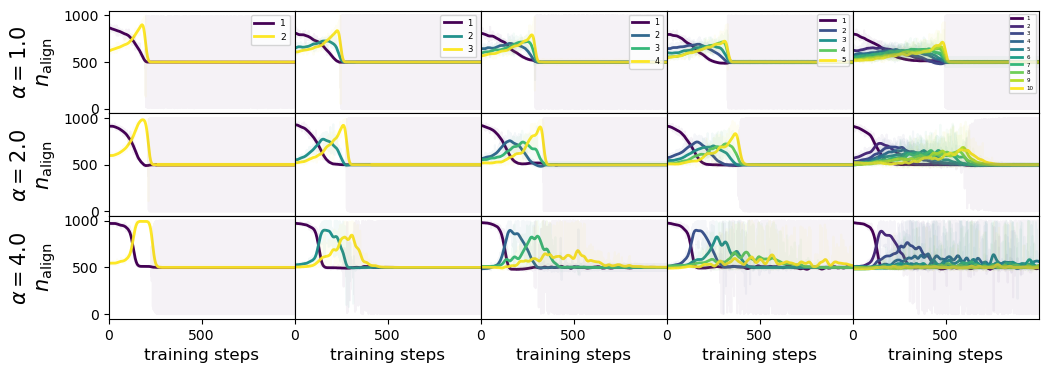

In [4]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

cmap = plt.get_cmap('viridis') 

alphas = [1.0, 2.0, 4.0]
n_tasks = [2, 3, 4, 5, 10]

plt.figure(figsize=(12,4))

for j in range(3):
    for k in range(5):
        plt.subplot(3, 5, j*5+k+1)

        alpha = alphas[j]
        n_task = n_tasks[k]

        loaded_data = np.load(f"./results/effind_ntask_{alpha}_{n_task}.npz")
        mydict = dict(loaded_data)
        n_uses = mydict['n_uses']

        for i in range(n_task):
            plt.plot(gaussian_filter1d(n_uses[:,i],sigma=10), color=cmap(i/(n_task-1)), lw=2)


        for i in range(n_task):
            plt.plot(n_uses[:,i], alpha=0.05, color=cmap(i/(n_task-1)))

        plt.xlim(0,1000)

        if j == 0:
            plt.legend(np.arange(n_task)+1, loc='upper right', fontsize=80/(n_task+10))
        if j == 2:
            plt.xlabel('training steps', fontsize=12)
            plt.xticks([0,500])
        else:
            plt.xticks([])
        if k == 0:
            plt.ylabel(r'$\alpha=$' + f'{alpha}' + ' \n' + r'$n_{\rm align}$', fontsize=15)
        else:
            plt.yticks([])
        plt.ylim(-50,1050)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/effind_ntask_nalign.pdf', bbox_inches='tight')

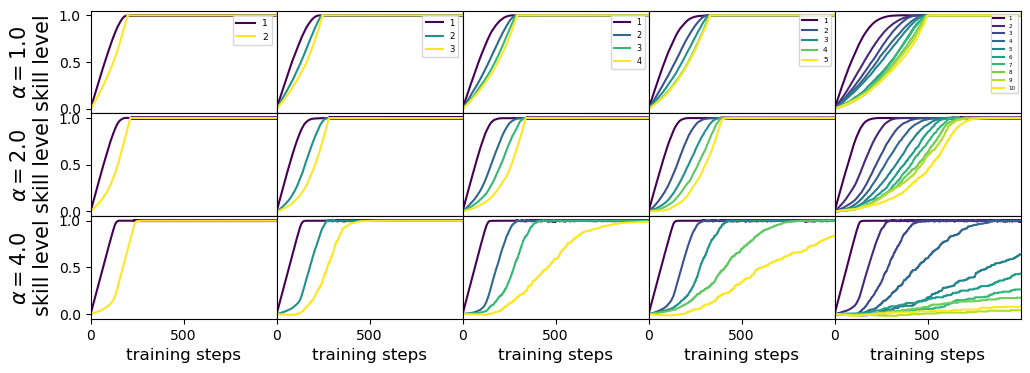

In [2]:
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

cmap = plt.get_cmap('viridis') 

alphas = [1.0, 2.0, 4.0]
n_tasks = [2, 3, 4, 5, 10]

plt.figure(figsize=(12,4))

for j in range(3):
    for k in range(5):
        plt.subplot(3, 5, j*5+k+1)

        alpha = alphas[j]
        n_task = n_tasks[k]

        loaded_data = np.load(f"./results/effind_ntask_{alpha}_{n_task}.npz")
        mydict = dict(loaded_data)
        task_abilities = mydict['task_abilities']
        
        for i in range(n_task):
            plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))

        plt.xlim(0,1000)

        if j == 0:
            plt.legend(np.arange(n_task)+1, loc='upper right', fontsize=80/(n_task+10))
        if j == 2:
            plt.xlabel('training steps', fontsize=12)
            plt.xticks([0,500])
        else:
            plt.xticks([])
        if k == 0:
            plt.ylabel(r'$\alpha=$' + f'{alpha}' + ' \n' + 'skill level', fontsize=15)
        else:
            plt.yticks([])
        plt.ylim(-0.05,1.05)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/effind_ntask_skill.pdf', bbox_inches='tight')

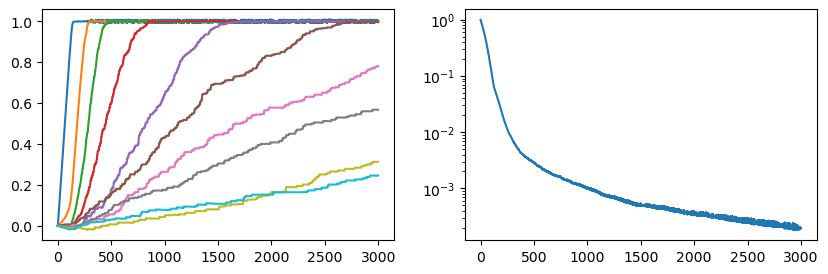

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i])
    
#plt.xlim(1,300)
#plt.xscale('log')
    
plt.subplot(1,2,2)
plt.plot(losses)
plt.yscale('log')


In [59]:
import copy
losses_1 = copy.deepcopy(losses)

In [63]:
import copy
losses_n = copy.deepcopy(losses)

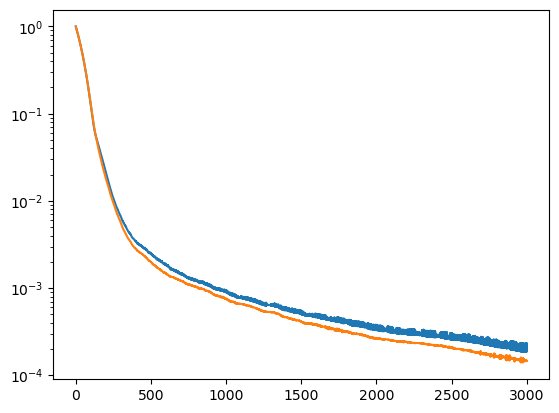

In [64]:
import matplotlib.pyplot as plt

plt.plot(losses_1)
plt.plot(losses_n)
plt.yscale('log')
#plt.xscale('log')

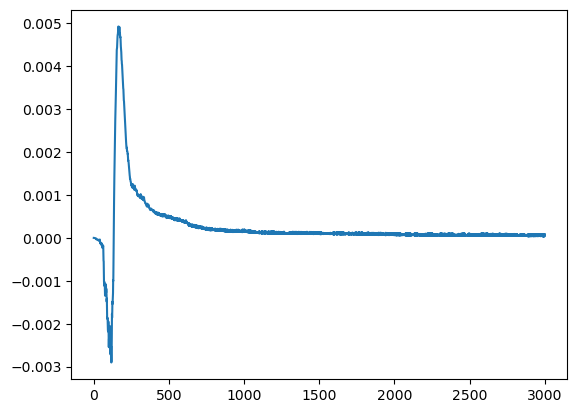

In [65]:
plt.plot(losses_1 - losses_n)

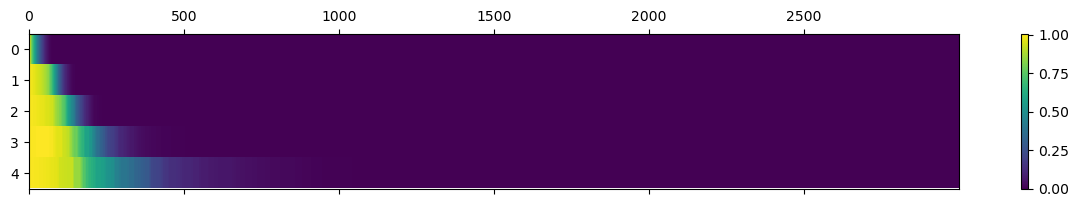

In [5]:
plt.matshow(losses_skill.T,aspect=100)
plt.colorbar()

In [214]:
import copy

l = np.ones(n_task,)

lr = learning_rate * np.sqrt(dim)
n_steps2 = 10000

ls = []

for i in range(n_steps2):
    fg = prob * l
    fg_norm = fg/(np.sum(fg) + 0.01)
    l -= lr * fg_norm
    l = np.maximum(l, 0.)
    #l = np.exp(-lr*prob/(np.sum(fg)+0.01)) * l
    ls.append(copy.deepcopy(l))
    
ls = np.array(ls)

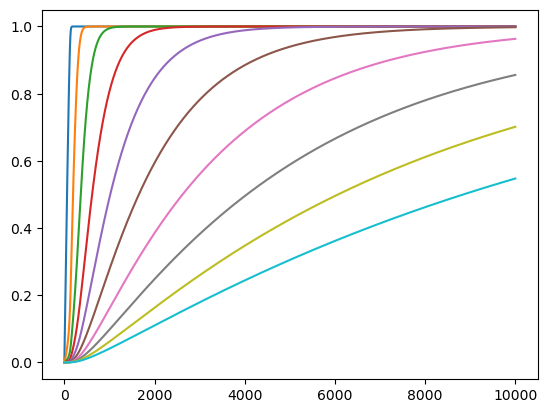

In [215]:
for i in range(n_task):
    plt.plot(1-ls[:,i])

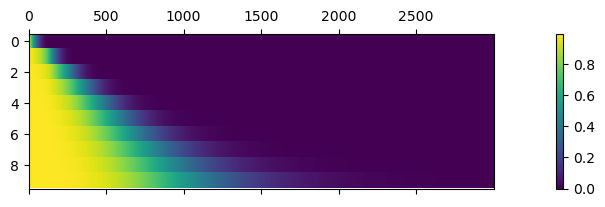

In [114]:
plt.matshow(ls.T**2,aspect=100)
plt.colorbar()